In [179]:
%reset -f
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sin, cos
from numpy.fft import fft, fftfreq


In [180]:
# Define a custom activation function 
class SinActivation(nn.Module):
    def forward(self, input):
        out = torch.sin(input)
        return out

# Define custom training function (sin(2x))
class TrainingFunctions:
    def __init__(self):
        pass

    def sin(self, x):
        return np.sin(x)

    def cos(self, x):
        return np.cos(x)

    def sin_2x(self, x):
        return np.sin(2*x)

    def sin_sqx(self, x):
        return np.sin(x) * np.sin(x)

    def odd_func(self, x):
        return np.sin(x) + 3*np.sin(2*x)

# Define the custom loss function using L1 norm
def custom_l1_loss(output, target):
    loss = torch.abs(output - target).mean()  # L1 norm (mean absolute error)
    return loss

def custom_fft_loss(output, target, x):

    dx = x[1] - x[0]
    dx = float(dx)
    freqs = torch.fft.fftfreq(x.size(0), d=dx)
    fft_output = torch.fft.fft(output)
    fft_target = torch.fft.fft(target)

    power_spectrum_output = (fft_output / len(fft_output)).abs() ** 2
    power_spectrum_target = (fft_target / len(fft_target)).abs() ** 2

    loss = (power_spectrum_output - power_spectrum_target) ** 2

    return loss.sum()  # Return the sum of the squared differences as the loss


def custom_fft_loss(output, target, x):
    dx = x[1] - x[0]
    dx = float(dx)
    
    # Compute FFT of output and target
    fft_output = torch.fft.fft(output)
    fft_target = torch.fft.fft(target)
    
    # Calculate the size for padding (3/2 times the original size)
    n = fft_output.size(0)
    n_padded = int(3 * n // 2)
    
    # Split the FFT output into low and high frequency parts
    mid_point = n // 2
    pos_freqs_output = fft_output[:mid_point]
    neg_freqs_output = fft_output[mid_point:]
    
    pos_freqs_target = fft_target[:mid_point]
    neg_freqs_target = fft_target[mid_point:]
    
    # Zero-padding in the middle
    padded_fft_output = torch.zeros(n_padded, dtype=fft_output.dtype)
    padded_fft_target = torch.zeros(n_padded, dtype=fft_output.dtype)

    for i in range(0,n_padded):
        if i < mid_point:
            padded_fft_output[i] = pos_freqs_output[i]
            padded_fft_target[i] = pos_freqs_target[i]

        elif i >= mid_point and i <= 2*mid_point:
            padded_fft_output[i] = 0 + 1j*0
            padded_fft_target[i] = 0 + 1j*0

        elif i > 2*mid_point:
            padded_fft_output[i] = neg_freqs_output[i-(2*mid_point+1)]
            padded_fft_target[i] = neg_freqs_target[i-(2*mid_point+1)]

        else:
            print('out of bounds!!')


 
    # Compute power spectra
    power_spectrum_output = (padded_fft_output / n_padded).abs() ** 2
    power_spectrum_target = (padded_fft_target / n_padded).abs() ** 2
    
    # Compute the loss
    loss = (power_spectrum_output - power_spectrum_target) ** 2

    return loss.sum()




    

In [181]:
temp = np.linspace(-1,1,10)
temp = torch.from_numpy(temp)

pad_size = 6
pad_left = pad_size // 2
pad_right = pad_size - pad_left

torch.nn.functional.pad(temp, (pad_left, pad_right), mode='constant', value=0)



tensor([ 0.0000,  0.0000,  0.0000, -1.0000, -0.7778, -0.5556, -0.3333, -0.1111,
         0.1111,  0.3333,  0.5556,  0.7778,  1.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64)

In [182]:
"""A basic neural network with 3 layers of 5 neurons each"""
# This uses ReLu activation
class SinNet(nn.Module):
    def __init__(self):
        super(SinNet, self).__init__()
        self.fc1 = nn.Linear(1, 32)  # Input layer to hidden layer
        self.fc2 = nn.Linear(32, 32)  # Hidden layer to hidden layer
        self.fc3 = nn.Linear(32, 1)   # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

"""NN with periodic activation function"""
# This uses sin activation
class SinNetPeriodic(nn.Module):
    def __init__(self):
        super(SinNetPeriodic, self).__init__()
        self.fc1 = nn.Linear(1, 32)  # Input layer to hidden layer
        self.sin1 = SinActivation()  # Custom periodic activation
        self.fc2 = nn.Linear(32, 32)  # Hidden layer to hidden layer
        self.sin2 = SinActivation()  # Custom periodic activation
        self.fc3 = nn.Linear(32, 1)   # Hidden layer to output layer

    def forward(self, x):
        x = self.sin1(self.fc1(x))
        x = self.sin2(self.fc2(x))
        x = self.fc3(x)
        return x

"""NN with Dropout Regularization"""
# Randomly turn off neurons during training with probability p
# Promotes redundancy as each training iteration uses a different 
# subset of the neurons. All neurons are used during inference
class SinNetDropout(nn.Module):
    def __init__(self):
        super(SinNetDropout, self).__init__()
        self.fc1 = nn.Linear(1, 5)  # Input layer to hidden layer
        self.fc2 = nn.Linear(5, 5)  # Hidden layer to hidden layer
        self.fc3 = nn.Linear(5, 1)   # Hidden layer to output layer
        self.dropout = nn.Dropout(p=0.3)  # Dropout regularization

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

"""NN with periodic activation and dropout regularization"""
class SinNetPeriodicDropout(nn.Module):
    def __init__(self):
        super(SinNetPeriodicDropout, self).__init__()
        self.fc1 = nn.Linear(1, 32)  # Increased neurons
        self.sin1 = SinActivation()  # Custom periodic activation
        self.fc2 = nn.Linear(32, 32)  # Additional layer
        self.sin2 = SinActivation()  # Custom periodic activation
        self.fc3 = nn.Linear(32, 32)  # Increased neurons
        self.sin3 = SinActivation()  # Custom periodic activation
        self.fc4 = nn.Linear(32, 1)  # Output layer
        self.dropout = nn.Dropout(p=0.3)  # Dropout regularization

    def forward(self, x):
        x = self.dropout(self.sin1(self.fc1(x)))
        x = self.dropout(self.sin2(self.fc2(x)))
        x = self.dropout(self.sin3(self.fc3(x)))
        x = self.fc4(x)
        return x

"""NN with a single neuron"""
class SinNetSingleNeuron(nn.Module):
    def __init__(self):
        super(SinNetSingleNeuron, self).__init__()
        self.fc1 = nn.Linear(1, 1)  # Single layer with one neuron
        self.sin = SinActivation()  # Custom periodic activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.sin(x)
        return x


In [183]:

"""
models:
    SinNet
    SinNetPeriodic
    SinNetDropout
    SinNetPeriodicDropout
    SinNetSingleNeuron

training functions:
    sin
    cos
    sin_2x
    sin_sqx
    odd_func
"""

##############...INPUTS...###################
model = SinNetPeriodicDropout()
learning_rate = 0.01

training_epochs = 10000
num_training_data_points = 5000
training_range = [-4*pi, 4*pi]

num_testing_data_points = 4000
testing_range = [-16*pi, 16*pi]

func = TrainingFunctions()
training_function = func.odd_func
#########...END OF USER INPUTS...############


In [184]:
# Generate training data
x = np.linspace(training_range[0], training_range[1], num_training_data_points)
y = training_function(x)

# Convert data to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Initialize weights manually for single neuron case
# if model is SinNetSingleNeuron:
if isinstance(model, SinNetSingleNeuron):
    print('Initializing weight and bias for the single neuron')
    wt = 2.25
    bi = 0.5
    nn.init.constant_(model.fc1.weight, wt)
    nn.init.constant_(model.fc1.bias, bi)
    [weight] = model.fc1.weight.data.numpy()
    [bias] = model.fc1.bias.data.numpy()
    print(f'weight = {weight}, bias = {bias}')

criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer


In [185]:
print_every = int(0.1*training_epochs)

for epoch in range(training_epochs):
    model.train()
    optimizer.zero_grad()  # Zero the gradient buffers

    # Forward pass
    outputs = model(x_train)
    # loss = criterion(outputs, y_train)
    loss = custom_fft_loss(outputs, y_train, x_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch+1) % print_every == 0:
        # Print the weights and bias
        # [weight] = model.fc1.weight.data.numpy()
        # [bias] = model.fc1.bias.data.numpy()
        print(f'Epoch [{epoch+1}/{training_epochs}], Loss: {loss.item():.4f}')


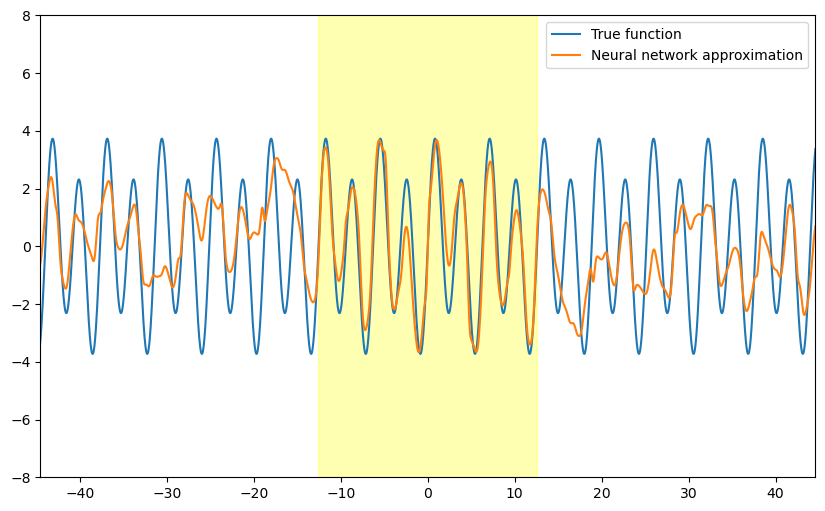

In [ ]:
# Set the model to evaluation mode
model.eval()

# Generate test data
x_test = np.linspace(testing_range[0], testing_range[1], num_testing_data_points)
y_test = training_function(torch.tensor(x_test))

# Predict the values
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label='True function')
plt.plot(x_test, y_pred, label='Neural network approximation')
plt.axvspan(x_train[0].item(), x_train[-1].item(), color='yellow', alpha=0.3)  # Mark the training region
plt.ylim([-8,8])
plt.xlim([min(x_train)-32,max(x_train)+32])
plt.legend()
plt.show()


In [ ]:
from numpy.fft import fft, fftfreq
dx = x_test[1] - x_test[0]
freqs = fftfreq(x_test.size, dx)
fft_y_pred = fft(np.sin(x_test))

power_spectrum = abs(fft_y_pred/len(fft_y_pred))**2

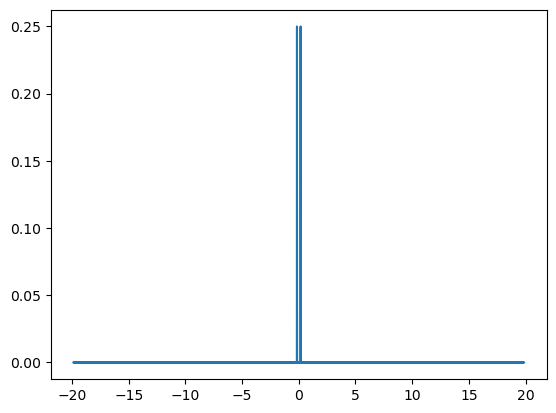

In [ ]:
plt.plot(np.real(freqs),power_spectrum)